In [1]:
#================1.retrieve data===========================
import sys
import os
import urllib.request
import getpass
import requests

def verify_datasize(filename, expected_bytes):
    statinfo = os.stat(filename)
    if statinfo.st_size == expected_bytes:
        print("Found and verified.", filename)
    else:
        raise Exception("Failed to veryfile file [{}], file_size [{}], expected_size [{}].".format(filename, statinfo.st_size, expected_bytes))

        
#Reports every 5% change in download progress
last_percent_reported = None
def download_progress_hook(count, blockSize, totalSize):
    global last_percent_reported
    percent = int(count * blockSize * 100) / totalSize
    if last_percent_reported != percent:
        if percent % 5 == 0:
            sys.stdout.write("%s%%" % percent)
        else:
            sys.stdout.write(".")
        sys.stdout.flush()
    last_percent_reported = percent

    
#download a file from url and check size
data_root = "." #data saved local directory

urls = [['https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/download/train.zip', 569918665],
      ['https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/download/test.zip',284478493]]
headers = {
    'User-Agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/59.0.3071.115 Safari/537.36'
}

def download_data_without_Authentication(url, expected_bytes, force=False):
    dest_filename = os.path.join(data_root,url.split('/')[-1])
    if force or not os.path.exists(dest_filename):
        print("Attempting to download data from :", url)
        urllib.request.urlretrieve(url, dest_filename, download_progress_hook)
        print("\nDownload completed!")
    verify_datasize(dest_filename, expected_bytes)
    return dest_filename

#first you must login to Kaggle, direct to the specific competition, and accept rules competition, or post will direct to rules page.
#eg:dogs-vs-cats's rule page is:https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/rules
def download_data_with_Authentication(url, expected_bytes, force=False):
    dest_filename = os.path.join(data_root, url.split('/')[-1])
    if force or not os.path.exists(dest_filename):
        print("Attempting to download data from :", url)
        user_name = input("Enter username:")
        pwd = getpass.getpass("Enter password:")
        authen_info = {'UserName':user_name, 'Password': pwd}
        
        #To go to the redirect url
        resp = requests.get(url, headers=headers)
        print("Redirected:", resp.url)

        #To login and get data
        resp = requests.post(resp.url, data = authen_info, headers=headers,stream=True)
        print("Redirected:", resp.url)
        print("Status:", resp.status_code)
        
        if resp.status_code == requests.codes.ok:
            f = open(dest_filename, 'wb')
            for chunk in resp.iter_content(chunk_size = 512 * 1024):# Reads 512KB at a time into memory
                if chunk: # filter out keep-alive new chunks
                    f.write(chunk)
            f.close()
            print("\nDownload completed!")
        else:
            raise Exception("\nDownload failed")
        
    verify_datasize(dest_filename, expected_bytes)
    return dest_filename
   

train_filename = download_data_with_Authentication(urls[0][0], urls[0][1])
test_filename = download_data_with_Authentication(urls[1][0], urls[1][1])            

Found and verified. ./train.zip
Found and verified. ./test.zip


In [2]:
#=================2.unzip file and explore image files======================
import zipfile

def unzip_file(filename):
    file_to_unzip = zipfile.ZipFile(filename)
    file_to_unzip.extractall()
    file_to_unzip.close()
    print("Unzip file succeed.", filename)
    
unzip_file(train_filename)
unzip_file(test_filename)
    

Unzip file succeed. ./train.zip
Unzip file succeed. ./test.zip


In [1]:
import os
import shutil
from PIL import Image

dat_dir = "./trainprocess"
cate_dat_dir = dat_dir + "/categorized"
train_dat_dir = dat_dir + "/train"
valid_dat_dir = dat_dir + "/valid"
categories = ["cat", "dog"]

def rebuild_dir(dir):
    if os.path.exists(dir):
        shutil.rmtree(dir)
    os.mkdir(dir)
        
def rearrange_data(category_name):
    if category_name not in categories:
        raise Exception("\n category [{}] not exists.", category_name)
        
    category_data_dir = cate_dat_dir + "/" + category_name
    rebuild_dir(category_data_dir)
    
    train_filenames = os.listdir('./train')
    train_category = filter(lambda x:x[:3].upper() ==category_name.upper() , train_filenames)
    train_count = 0
    for filename in train_category:
        train_count += 1
        shutil.copy("./train/" + filename, category_data_dir)
    return train_count
 
def get_image_properties(category_name):
    if category_name not in categories:
        raise Exception("\n category {{}] not exists.", category_name)
        
    category_map = {}
    path = cate_dat_dir + "/" + category_name + "/"
    filenames = os.listdir(path)
    for filename in filenames:
        im = Image.open(path + filename)
        category_map[filename] = [im.format, im.mode, im.width, im.height]
    return category_map
'''
rebuild_dir(dat_dir)
rebuild_dir(cate_dat_dir)
dog_counts = rearrange_data("dog")
cat_counts = rearrange_data("cat")
image_properties_dog = get_image_properties("dog")
image_properties_cat = get_image_properties("cat")
'''

'\nrebuild_dir(dat_dir)\nrebuild_dir(cate_dat_dir)\ndog_counts = rearrange_data("dog")\ncat_counts = rearrange_data("cat")\nimage_properties_dog = get_image_properties("dog")\nimage_properties_cat = get_image_properties("cat")\n'

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

columns = ['format', 'mode', 'width', 'height']

df_dog = pd.DataFrame(image_properties_dog).transpose()
df_cat = pd.DataFrame(image_properties_cat).transpose()
df_dog.columns = columns
df_cat.columns = columns

print("\ndogs count : [{}]. cats count:[{}]".format(dog_counts, cat_counts))

print("\ndogs group by format, mode:")
print(df_dog.groupby(['format', 'mode'])['width'].count())
print("\ncats group by format, mode:")
print(df_cat.groupby(['format', 'mode'])['width'].count())


plt.figure(figsize=(16,16))
plt.subplot(2, 1, 1)
plt.scatter(x=df_dog['width'], y=df_dog['height'], s=10, marker=".", color='red')
plt.scatter(x=df_cat['width'], y=df_cat['height'], s=10, marker="*", color='blue')
plt.legend(['dogs','cats'], loc='center right')
plt.xlabel('widht')
plt.ylabel('height')
plt.title("image size")
plt.subplots_adjust(hspace = .5)

plt.subplot(2,1,2)
plt.boxplot([df_dog['width'], df_dog['height'], df_cat['width'], df_cat['height']], showmeans=True)
plt.xticks([1,2,3,4], ['dog-width', 'dog-height', 'cat-width', 'cat-height'])
#plt.subplots_adjust(hspace = .5)
plt.show()

print("\ndogs width max/min:\n",df_dog.loc[[df_dog['width'].idxmax(),df_dog['width'].idxmin()]])
print("\ndogs height max/min:\n",df_dog.loc[[df_dog['height'].idxmax(),df_dog['height'].idxmin()]])
print("\ncats width max/mai:\n",df_cat.loc[[df_cat['width'].idxmax(),df_cat['width'].idxmin()]])
print("\ncats height max/min:\n",df_cat.loc[[df_cat['height'].idxmax(),df_cat['height'].idxmin()]])

NameError: name 'image_properties_dog' is not defined

In [2]:
#========================3.split and preprocess data================================
import random

def split_train_valid(category_name, test_percent, random_seed=None, create_link=False):
    if category_name not in categories:
        raise Exception("\n category [{}] note exists.", category_name)
    if test_percent <=0 or test_percent >=1:
        raise Exception("\n test_percent must be in (0,1)")
        
    source_dir = cate_dat_dir + "/" + category_name + "/"
    dest_train_dir = train_dat_dir + "/" + category_name + "/"
    dest_valid_dir = valid_dat_dir + "/" + category_name + "/"
    
    filenames = os.listdir(source_dir)
    total_size = len(filenames)
    test_size = int(total_size * test_percent)
    train_size = total_size - test_size
    
    if not random_seed is None:
        random.seed(random_seed)
    random.shuffle(filenames)
    rebuild_dir(dest_train_dir)
    rebuild_dir(dest_valid_dir)
    for i in range(0, total_size):
        if i < test_size:
            dest_dir = dest_valid_dir
        else:
            dest_dir = dest_train_dir
        
        if create_link == True:
                os.symlink(source_dir + filenames[i], dest_dir + filenames[i])
        else:
                shutil.copy(source_dir + filenames[i], dest_dir)
                
    return train_size, test_size


Using TensorFlow backend.


Found 17500 images belonging to 2 classes.
Found 7500 images belonging to 2 classes.
Epoch 1/150
547/547 [==============================] - 1114s - loss: 0.6906 - acc: 0.5453 - val_loss: 0.6313 - val_acc: 0.6328
Epoch 2/150
547/547 [==============================] - 1103s - loss: 0.6173 - acc: 0.6619 - val_loss: 0.5961 - val_acc: 0.7020
Epoch 3/150
547/547 [==============================] - 1107s - loss: 0.5538 - acc: 0.7125 - val_loss: 0.4672 - val_acc: 0.7651
Epoch 4/150
547/547 [==============================] - 1109s - loss: 0.4577 - acc: 0.7818 - val_loss: 0.3760 - val_acc: 0.8303
Epoch 5/150
547/547 [==============================] - 1109s - loss: 0.3814 - acc: 0.8260 - val_loss: 0.3059 - val_acc: 0.8631
Epoch 6/150
547/547 [==============================] - 1109s - loss: 0.3308 - acc: 0.8525 - val_loss: 0.2533 - val_acc: 0.8892
Epoch 7/150
547/547 [==============================] - 1107s - loss: 0.2877 - acc: 0.8779 - val_loss: 0.2243 - val_acc: 0.9017
Epoch 8/150
547/547 [=====

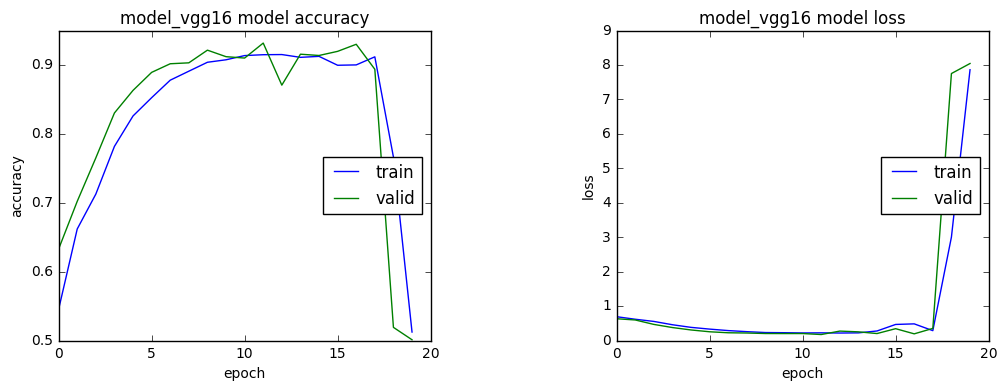

In [3]:
#model_vgg16
import ModelUtil
import importlib
importlib.reload(ModelUtil)
from keras.layers import *
from keras import optimizers

dat_dir = "./trainprocess"
cate_dat_dir = dat_dir + "/categorized"
train_dat_dir = dat_dir + "/train"
valid_dat_dir = dat_dir + "/valid"
categories = ["cat", "dog"]

rebuild_dir(train_dat_dir)
rebuild_dir(valid_dat_dir)
dog_train_size, dog_test_size = split_train_valid("dog", 0.3, 1234, False)
cat_train_size, cat_test_size = split_train_valid("cat", 0.3, 1234, False)

total_train_size = 17500 #dog_train_size + cat_train_size
total_valid_size = 7500 #dog_test_size + cat_test_size
image_width = 224
image_height = 224
image_size = (image_width,image_height)
perbatch = 32
poch_num = 150


name_vgg16 = "model_vgg16" #learning reate too high, acc suddenly drop, loss suddenly raise
model_vgg16 = ModelUtil.model_vgg16(image_width, image_height)
rmsp = optimizers.RMSprop(lr=0.0001)
model_vgg16.compile(optimizer=rmsp, loss='binary_crossentropy', metrics=['accuracy'])
ModelUtil.visualize_model(model_vgg16, model_name=name_vgg16)
history_vgg16 = ModelUtil.train_data_earlystopping(model_vgg16, model_name=name_vgg16, epoch=poch_num,
                          image_size = (image_width, image_height), num_perbatch=perbatch,
                          train_dir=train_dat_dir, train_size=total_train_size,
                          valid_dir=valid_dat_dir, valid_size=total_valid_size)
ModelUtil.visualize_history(history_vgg16, model_name=name_vgg16)
#ModelUtil.predict_data(model_vgg16, model_name=name_vgg16, 
#                 image_size=(image_width, image_height), 
#                 num_perbatch=perbatch)
ModelUtil.save_model(model_vgg16, model_name=name_vgg16)

Using TensorFlow backend.


Found 17500 images belonging to 2 classes.
Found 7500 images belonging to 2 classes.
Epoch 1/150
547/547 [==============================] - 1129s - loss: 0.6679 - acc: 0.5717 - val_loss: 0.6384 - val_acc: 0.6161
Epoch 2/150
547/547 [==============================] - 1116s - loss: 0.5961 - acc: 0.6693 - val_loss: 0.5279 - val_acc: 0.7412
Epoch 3/150
547/547 [==============================] - 1117s - loss: 0.5471 - acc: 0.7168 - val_loss: 0.5232 - val_acc: 0.7351
Epoch 4/150
547/547 [==============================] - 1117s - loss: 0.5197 - acc: 0.7405 - val_loss: 0.4880 - val_acc: 0.7643
Epoch 5/150
547/547 [==============================] - 1117s - loss: 0.4940 - acc: 0.7608 - val_loss: 0.4780 - val_acc: 0.7695
Epoch 6/150
547/547 [==============================] - 1117s - loss: 0.4697 - acc: 0.7762 - val_loss: 0.4733 - val_acc: 0.7700
Epoch 7/150
547/547 [==============================] - 1118s - loss: 0.4465 - acc: 0.7911 - val_loss: 0.4217 - val_acc: 0.8076
Epoch 8/150
547/547 [=====

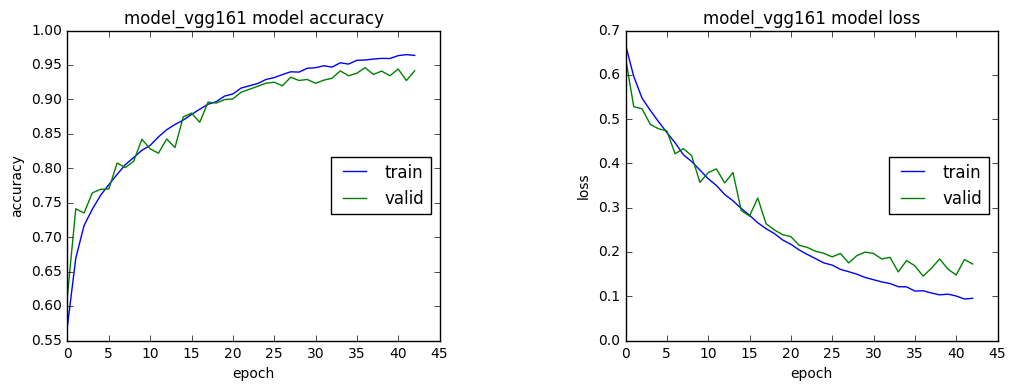

In [3]:
#model_vgg161
import ModelUtil
import importlib
importlib.reload(ModelUtil)
from keras.layers import *
from keras import optimizers

dat_dir = "./trainprocess"
cate_dat_dir = dat_dir + "/categorized"
train_dat_dir = dat_dir + "/train"
valid_dat_dir = dat_dir + "/valid"
categories = ["cat", "dog"]

rebuild_dir(train_dat_dir)
rebuild_dir(valid_dat_dir)
dog_train_size, dog_test_size = split_train_valid("dog", 0.3, 1234, False)
cat_train_size, cat_test_size = split_train_valid("cat", 0.3, 1234, False)

total_train_size = 17500 #dog_train_size + cat_train_size
total_valid_size = 7500 #dog_test_size + cat_test_size
image_width = 224
image_height = 224
image_size = (image_width,image_height)
perbatch = 32
poch_num = 150


name_vgg161 = "model_vgg161"
model_vgg161 = ModelUtil.model_vgg161(image_width, image_height)
rmsp = optimizers.RMSprop(lr=0.00001)
model_vgg161.compile(optimizer=rmsp, loss='categorical_crossentropy', metrics=['accuracy'])
ModelUtil.visualize_model(model_vgg161, model_name=name_vgg161)
history_vgg161 = ModelUtil.train_data_earlystopping(model_vgg161, model_name=name_vgg161, epoch=poch_num,
                          image_size = (image_width, image_height), num_perbatch=perbatch,
                          train_dir=train_dat_dir, train_size=total_train_size,
                          valid_dir=valid_dat_dir, valid_size=total_valid_size)
ModelUtil.visualize_history(history_vgg161, model_name=name_vgg161)
#ModelUtil.predict_data(model_vgg161, model_name=name_vgg16, 
#                 image_size=(image_width, image_height), 
#                 num_perbatch=perbatch)
ModelUtil.save_model(model_vgg161, model_name=name_vgg161)

56967168/58889256 [============================>.] - ETA: 0sFound 17500 images belonging to 2 classes.
Found 7500 images belonging to 2 classes.
Epoch 1/150
274/274 [==============================] - 346s - loss: 0.6012 - acc: 0.6745 - val_loss: 0.4222 - val_acc: 0.8459
Epoch 2/150
274/274 [==============================] - 346s - loss: 0.4609 - acc: 0.7941 - val_loss: 0.3372 - val_acc: 0.8621
Epoch 3/150
274/274 [==============================] - 345s - loss: 0.4019 - acc: 0.8257 - val_loss: 0.3303 - val_acc: 0.8583
Epoch 4/150
274/274 [==============================] - 346s - loss: 0.3613 - acc: 0.8412 - val_loss: 0.2856 - val_acc: 0.8772
Epoch 5/150
274/274 [==============================] - 346s - loss: 0.3394 - acc: 0.8553 - val_loss: 0.2568 - val_acc: 0.8919
Epoch 6/150
274/274 [==============================] - 346s - loss: 0.3186 - acc: 0.8629 - val_loss: 0.2538 - val_acc: 0.8945
Epoch 7/150
274/274 [==============================] - 346s - loss: 0.3008 - acc: 0.8716 - val_loss

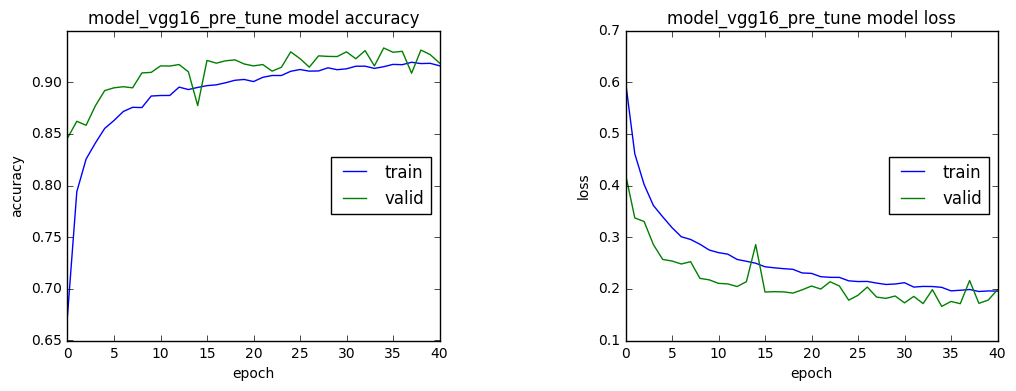

In [ ]:
#model_vgg16_pre_tune
import ModelUtil
import importlib
importlib.reload(ModelUtil)
from keras.layers import *
from keras import optimizers

dat_dir = "./trainprocess"
cate_dat_dir = dat_dir + "/categorized"
train_dat_dir = dat_dir + "/train"
valid_dat_dir = dat_dir + "/valid"
categories = ["cat", "dog"]

#rebuild_dir(train_dat_dir)
#rebuild_dir(valid_dat_dir)
dog_train_size, dog_test_size = split_train_valid("dog", 0.3, 1234, False)
cat_train_size, cat_test_size = split_train_valid("cat", 0.3, 1234, False)

total_train_size = 17500 #dog_train_size + cat_train_size
total_valid_size = 7500 #dog_test_size + cat_test_size
image_width = 224
image_height = 224
image_size = (image_width,image_height)
perbatch = 64
poch_num = 150


name_vgg16_pre_tune = "model_vgg16_pre_tune"
model_vgg16_pre_tune = ModelUtil.model_vgg16_pre_tune(image_width, image_height)
rmsp = optimizers.RMSprop(lr=0.00001)
sgd = optimizers.SGD(lr=0.001) 
model_vgg16_pre_tune.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['accuracy'])
ModelUtil.visualize_model(model_vgg16_pre_tune, model_name=name_vgg16_pre_tune)
history_vgg16_pre_tune = ModelUtil.train_data_earlystopping(model_vgg16_pre_tune, model_name=name_vgg16_pre_tune, epoch=poch_num,
                          image_size = (image_width, image_height), num_perbatch=perbatch,
                          train_dir=train_dat_dir, train_size=total_train_size,
                          valid_dir=valid_dat_dir, valid_size=total_valid_size)
ModelUtil.visualize_history(history_vgg16_pre_tune, model_name=name_vgg16_pre_tune)
#ModelUtil.predict_data(model_vgg16_pre_tune, model_name=name_vgg16_pre_tune, 
#                image_size=(image_width, image_height), 
#               num_perbatch=perbatch)
ModelUtil.save_model(model_vgg16_pre_tune, model_name=name_vgg16_pre_tune)

Found 17500 images belonging to 2 classes.
Found 7500 images belonging to 2 classes.
Epoch 1/150
274/274 [==============================] - 351s - loss: 0.6411 - acc: 0.6384 - val_loss: 0.5248 - val_acc: 0.8201
Epoch 2/150
274/274 [==============================] - 351s - loss: 0.5005 - acc: 0.7842 - val_loss: 0.3802 - val_acc: 0.8444
Epoch 3/150
274/274 [==============================] - 351s - loss: 0.4029 - acc: 0.8282 - val_loss: 0.2965 - val_acc: 0.8801
Epoch 4/150
274/274 [==============================] - 350s - loss: 0.3425 - acc: 0.8569 - val_loss: 0.2662 - val_acc: 0.8888
Epoch 5/150
274/274 [==============================] - 351s - loss: 0.3112 - acc: 0.8678 - val_loss: 0.2457 - val_acc: 0.9008
Epoch 6/150
274/274 [==============================] - 351s - loss: 0.2901 - acc: 0.8793 - val_loss: 0.2332 - val_acc: 0.9039
Epoch 7/150
274/274 [==============================] - 351s - loss: 0.2731 - acc: 0.8858 - val_loss: 0.2178 - val_acc: 0.9109
Epoch 8/150
274/274 [============

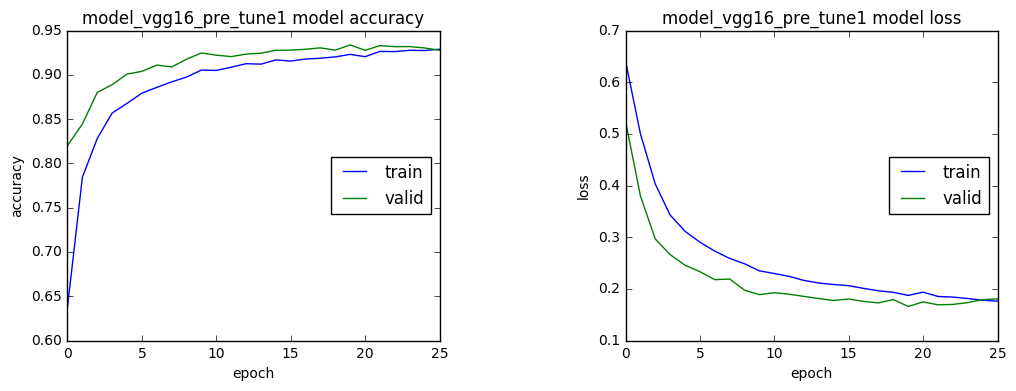

In [6]:
#model_vgg16_pre_tune1
import ModelUtil
import importlib
importlib.reload(ModelUtil)
from keras.layers import *
from keras import optimizers

dat_dir = "./trainprocess"
cate_dat_dir = dat_dir + "/categorized"
train_dat_dir = dat_dir + "/train"
valid_dat_dir = dat_dir + "/valid"
categories = ["cat", "dog"]

#rebuild_dir(train_dat_dir)
#rebuild_dir(valid_dat_dir)
dog_train_size, dog_test_size = split_train_valid("dog", 0.3, 1234, False)
cat_train_size, cat_test_size = split_train_valid("cat", 0.3, 1234, False)

total_train_size = 17500 #dog_train_size + cat_train_size
total_valid_size = 7500 #dog_test_size + cat_test_size
image_width = 224
image_height = 224
image_size = (image_width,image_height)
perbatch = 64
poch_num = 150


name_vgg16_pre_tune1 = "model_vgg16_pre_tune1"
model_vgg16_pre_tune1 = ModelUtil.model_vgg16_pre_tune1(image_width, image_height)
rmsp = optimizers.RMSprop(lr=0.00001)
sgd = optimizers.SGD(lr=0.0001, momentum=0.9, decay=1e-6, nesterov=True)
model_vgg16_pre_tune1.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['accuracy'])
ModelUtil.visualize_model(model_vgg16_pre_tune1, model_name=name_vgg16_pre_tune1)
history_vgg16_pre_tune1 = ModelUtil.train_data_earlystopping(model_vgg16_pre_tune1, model_name=name_vgg16_pre_tune1, epoch=poch_num,
                          image_size = (image_width, image_height), num_perbatch=perbatch,
                          train_dir=train_dat_dir, train_size=total_train_size,
                          valid_dir=valid_dat_dir, valid_size=total_valid_size)
ModelUtil.visualize_history(history_vgg16_pre_tune1, model_name=name_vgg16_pre_tune1)
#ModelUtil.predict_data(model_vgg16_pre_tune1, model_name=name_vgg16_pre_tune1, 
#                image_size=(image_width, image_height), 
#               num_perbatch=perbatch)
ModelUtil.save_model(model_vgg16_pre_tune1, model_name=name_vgg16_pre_tune1)

In [ ]:
#model_vgg16_pre_tune2
import ModelUtil
import importlib
importlib.reload(ModelUtil)
from keras.layers import *
from keras import optimizers

dat_dir = "./trainprocess"
cate_dat_dir = dat_dir + "/categorized"
train_dat_dir = dat_dir + "/train"
valid_dat_dir = dat_dir + "/valid"
categories = ["cat", "dog"]

#rebuild_dir(train_dat_dir)
#rebuild_dir(valid_dat_dir)
dog_train_size, dog_test_size = split_train_valid("dog", 0.3, 1234, False)
cat_train_size, cat_test_size = split_train_valid("cat", 0.3, 1234, False)

total_train_size = 17500 #dog_train_size + cat_train_size
total_valid_size = 7500 #dog_test_size + cat_test_size
image_width = 224
image_height = 224
image_size = (image_width,image_height)
perbatch = 16
poch_num = 150


name_vgg16_pre_tune2 = "model_vgg16_pre_tune2"
model_vgg16_pre_tune2 = ModelUtil.model_vgg16_pre_tune2(image_width, image_height)
rmsp = optimizers.RMSprop(lr=0.00001)
sgd = optimizers.SGD(lr=0.00005, momentum=0.9, decay=1e-6, nesterov=True)
adam = optimizers.Adam(lr=1e-5)
model_vgg16_pre_tune2.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
ModelUtil.visualize_model(model_vgg16_pre_tune2, model_name=name_vgg16_pre_tune2)
history_vgg16_pre_tune2 = ModelUtil.train_data_earlystopping(model_vgg16_pre_tune2, model_name=name_vgg16_pre_tune2, epoch=poch_num,
                          image_size = (image_width, image_height), num_perbatch=perbatch,
                          train_dir=train_dat_dir, train_size=total_train_size,
                          valid_dir=valid_dat_dir, valid_size=total_valid_size)
ModelUtil.visualize_history(history_vgg16_pre_tune2, model_name=name_vgg16_pre_tune2)
#ModelUtil.predict_data(model_vgg16_pre_tune2, model_name=name_vgg16_pre_tune2, 
#                image_size=(image_width, image_height), 
#               num_perbatch=perbatch)
ModelUtil.save_model(model_vgg16_pre_tune2, model_name=name_vgg16_pre_tune2)

Using TensorFlow backend.


56827904/58889256 [===========================>..] - ETA: 0sFound 17500 images belonging to 2 classes.
Found 7500 images belonging to 2 classes.
Epoch 1/150
1094/1094 [==============================] - 452s - loss: 0.4988 - acc: 0.7701 - val_loss: 0.3548 - val_acc: 0.8684
Epoch 2/150
1094/1094 [==============================] - 450s - loss: 0.3406 - acc: 0.8696 - val_loss: 0.2854 - val_acc: 0.8908
Epoch 3/150
1094/1094 [==============================] - 449s - loss: 0.2935 - acc: 0.8861 - val_loss: 0.2531 - val_acc: 0.8993
Epoch 4/150
1094/1094 [==============================] - 449s - loss: 0.2675 - acc: 0.8939 - val_loss: 0.2387 - val_acc: 0.9020
Epoch 5/150
1094/1094 [==============================] - 449s - loss: 0.2526 - acc: 0.8993 - val_loss: 0.2232 - val_acc: 0.9099
Epoch 6/150
1094/1094 [==============================] - 449s - loss: 0.2369 - acc: 0.9042 - val_loss: 0.2100 - val_acc: 0.9152
Epoch 7/150
1094/1094 [==============================] - 449s - loss: 0.2273 - acc: 0.9

Using TensorFlow backend.
/home/ubuntu/udacity/uda_machine_learning_capstone/ModelUtil.py:106: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (3, 3), activation="relu", padding="same", name="block1_cov1", input_shape=(150, 150,...)`
  model.add(Convolution2D(16, 3, 3, input_shape=(image_width, image_height,3), activation='relu', border_mode='same', name='block1_cov1'))
/home/ubuntu/udacity/uda_machine_learning_capstone/ModelUtil.py:107: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D((2, 2), padding="same", name="block1_pool1")`
  model.add(MaxPooling2D((2,2), border_mode='same', name='block1_pool1'))
/home/ubuntu/udacity/uda_machine_learning_capstone/ModelUtil.py:109: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu", padding="same", name="block2_cov1")`
  model.add(Convolution2D(32, 3, 3, activation='relu', border_mode='same', name='block2_cov1'))
/home/ubuntu/udacity/uda_machine_lea

Found 17500 images belonging to 2 classes.
Found 7500 images belonging to 2 classes.


/home/ubuntu/udacity/uda_machine_learning_capstone/ModelUtil.py:229: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  callbacks=[TensorBoard(log_dir=log_location)])
/home/ubuntu/udacity/uda_machine_learning_capstone/ModelUtil.py:229: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras.pre..., validation_data=<keras.pre..., epochs=80, steps_per_epoch=274, validation_steps=118, callbacks=[<keras.ca...)`
  callbacks=[TensorBoard(log_dir=log_location)])


Epoch 1/80
274/274 [==============================] - 135s - loss: 0.6286 - acc: 0.6264 - val_loss: 0.5406 - val_acc: 0.7231
Epoch 2/80
274/274 [==============================] - 129s - loss: 0.5508 - acc: 0.7145 - val_loss: 0.5425 - val_acc: 0.7293
Epoch 3/80
274/274 [==============================] - 131s - loss: 0.5117 - acc: 0.7484 - val_loss: 0.5279 - val_acc: 0.7335
Epoch 4/80
274/274 [==============================] - 130s - loss: 0.4789 - acc: 0.7699 - val_loss: 0.4425 - val_acc: 0.7949
Epoch 5/80
274/274 [==============================] - 130s - loss: 0.4531 - acc: 0.7851 - val_loss: 0.4328 - val_acc: 0.8008
Epoch 6/80
274/274 [==============================] - 129s - loss: 0.4285 - acc: 0.8015 - val_loss: 0.5559 - val_acc: 0.7385
Epoch 7/80
274/274 [==============================] - 130s - loss: 0.4085 - acc: 0.8106 - val_loss: 0.3957 - val_acc: 0.8223
Epoch 8/80
274/274 [==============================] - 133s - loss: 0.3955 - acc: 0.8200 - val_loss: 0.4084 - val_acc: 0.8155


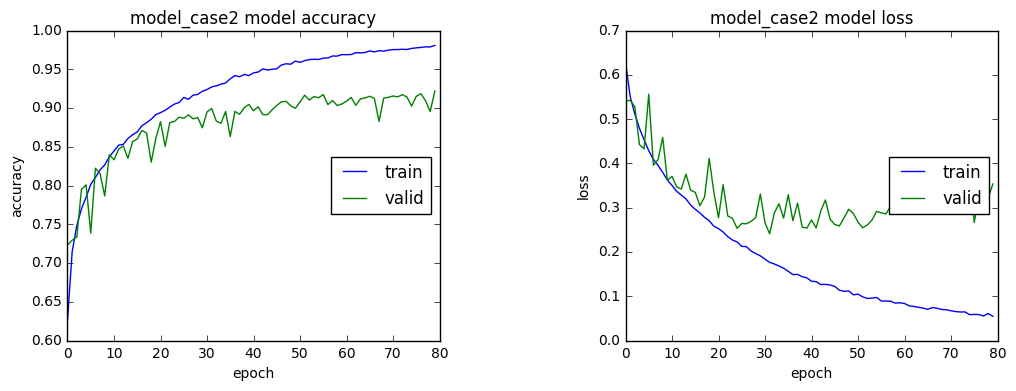

In [3]:
#model_case2
import ModelUtil
import importlib
importlib.reload(ModelUtil)
from keras import optimizers

dat_dir = "./trainprocess"
cate_dat_dir = dat_dir + "/categorized"
train_dat_dir = dat_dir + "/train"
valid_dat_dir = dat_dir + "/valid"
categories = ["cat", "dog"]

rebuild_dir(train_dat_dir)
rebuild_dir(valid_dat_dir)
dog_train_size, dog_test_size = split_train_valid("dog", 0.3, 1234, False)
cat_train_size, cat_test_size = split_train_valid("cat", 0.3, 1234, False)

total_train_size = 17500 #dog_train_size + cat_train_size
total_valid_size = 7500 #dog_test_size + cat_test_size
image_width = 150
image_height = 150
image_size = (image_width,image_height)
perbatch = 64
poch_num = 80


name_case2 = "model_case2"
model_case2 = ModelUtil.model_mycase2(image_width, image_height)
rmsp = optimizers.RMSprop(lr=0.0001)
model_case2.compile(optimizer=rmsp, loss='binary_crossentropy', metrics=['accuracy'])
ModelUtil.visualize_model(model_case2, model_name=name_case2)
history_case2 = ModelUtil.train_data(model_case2, model_name=name_case2, epoch=poch_num,
                          image_size = (image_width, image_height), num_perbatch=perbatch,
                          train_dir=train_dat_dir, train_size=total_train_size,
                          valid_dir=valid_dat_dir, valid_size=total_valid_size)
ModelUtil.visualize_history(history_case2, model_name=name_case2)
#ModelUtil.predict_data(model_case2, model_name=name_case2, 
#                 image_size=(image_width, image_height), 
#                 num_perbatch=perbatch)
ModelUtil.save_model(model_case2, model_name=name_case2)

Found 17500 images belonging to 2 classes.
Found 7500 images belonging to 2 classes.
Epoch 1/150
274/274 [==============================] - 135s - loss: 0.6894 - acc: 0.5217 - val_loss: 0.6549 - val_acc: 0.6068
Epoch 2/150
274/274 [==============================] - 131s - loss: 0.6274 - acc: 0.6325 - val_loss: 0.5581 - val_acc: 0.7025
Epoch 3/150
274/274 [==============================] - 131s - loss: 0.5563 - acc: 0.7161 - val_loss: 0.5060 - val_acc: 0.7535
Epoch 4/150
274/274 [==============================] - 132s - loss: 0.4979 - acc: 0.7599 - val_loss: 0.4657 - val_acc: 0.7771
Epoch 5/150
274/274 [==============================] - 132s - loss: 0.4569 - acc: 0.7899 - val_loss: 0.4060 - val_acc: 0.8161
Epoch 6/150
274/274 [==============================] - 132s - loss: 0.4266 - acc: 0.8060 - val_loss: 0.4229 - val_acc: 0.8021
Epoch 7/150
274/274 [==============================] - 131s - loss: 0.4054 - acc: 0.8130 - val_loss: 0.3836 - val_acc: 0.8227
Epoch 8/150
274/274 [============

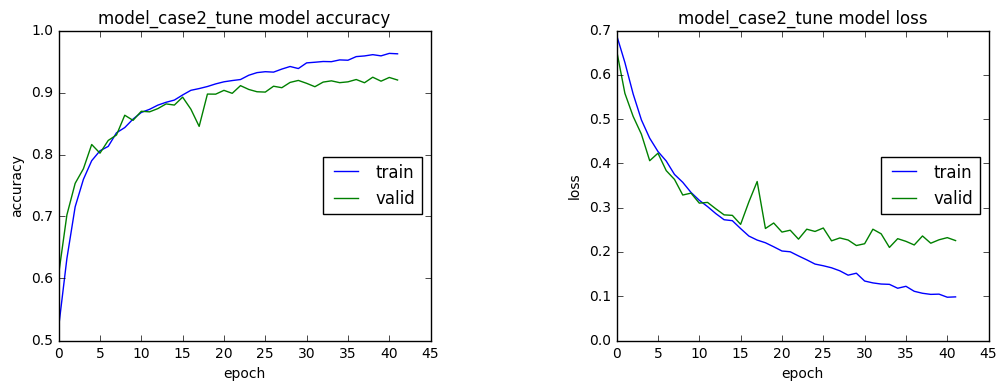

In [10]:
#model_case2_tune
import ModelUtil
import importlib
importlib.reload(ModelUtil)
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator

dat_dir = "./trainprocess"
cate_dat_dir = dat_dir + "/categorized"
train_dat_dir = dat_dir + "/train"
valid_dat_dir = dat_dir + "/valid"
categories = ["cat", "dog"]

rebuild_dir(train_dat_dir)
rebuild_dir(valid_dat_dir)
dog_train_size, dog_test_size = split_train_valid("dog", 0.3, 1234, False)
cat_train_size, cat_test_size = split_train_valid("cat", 0.3, 1234, False)

total_train_size = 17500 #dog_train_size + cat_train_size
total_valid_size = 7500 #dog_test_size + cat_test_size
image_width = 150
image_height = 150
image_size = (image_width,image_height)
perbatch = 64
poch_num = 150


name_case2_tune = "model_case2_tune"
model_case2_tune = ModelUtil.model_mycase2_tune(image_width, image_height)
adam = optimizers.Adam(lr=0.0001)
#rmsp = optimizers.RMSprop(lr=0.0001)
model_case2_tune.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
ModelUtil.visualize_model(model_case2_tune, model_name=name_case2_tune)
history_case2_tune = ModelUtil.train_data_earlystopping(model_case2_tune, model_name=name_case2_tune, epoch=poch_num,
                          image_size = (image_width, image_height), num_perbatch=perbatch,
                          train_dir=train_dat_dir, train_size=total_train_size,
                          valid_dir=valid_dat_dir, valid_size=total_valid_size)
                         
ModelUtil.visualize_history(history_case2_tune, model_name=name_case2_tune)
#ModelUtil.predict_data(model_case2_tune, model_name=name_case2_tune, 
#                 image_size=(image_width, image_height), 
#                 num_perbatch=perbatch)
ModelUtil.save_model(model_case2_tune, model_name=name_case2_tune)

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.
Epoch 1/150
313/313 [==============================] - 146s - loss: 0.8489 - acc: 0.5592 - val_loss: 0.7025 - val_acc: 0.6252
Epoch 2/150
313/313 [==============================] - 140s - loss: 0.6655 - acc: 0.6422 - val_loss: 0.6040 - val_acc: 0.7012
Epoch 3/150
313/313 [==============================] - 142s - loss: 0.5994 - acc: 0.6970 - val_loss: 0.5320 - val_acc: 0.7460
Epoch 4/150
313/313 [==============================] - 142s - loss: 0.5323 - acc: 0.7545 - val_loss: 0.5126 - val_acc: 0.7634
Epoch 5/150
313/313 [==============================] - 143s - loss: 0.4780 - acc: 0.7871 - val_loss: 0.4304 - val_acc: 0.8162
Epoch 6/150
313/313 [==============================] - 143s - loss: 0.4365 - acc: 0.8096 - val_loss: 0.3890 - val_acc: 0.8316
Epoch 7/150
313/313 [==============================] - 143s - loss: 0.4087 - acc: 0.8253 - val_loss: 0.3721 - val_acc: 0.8474
Epoch 8/150
313/313 [============

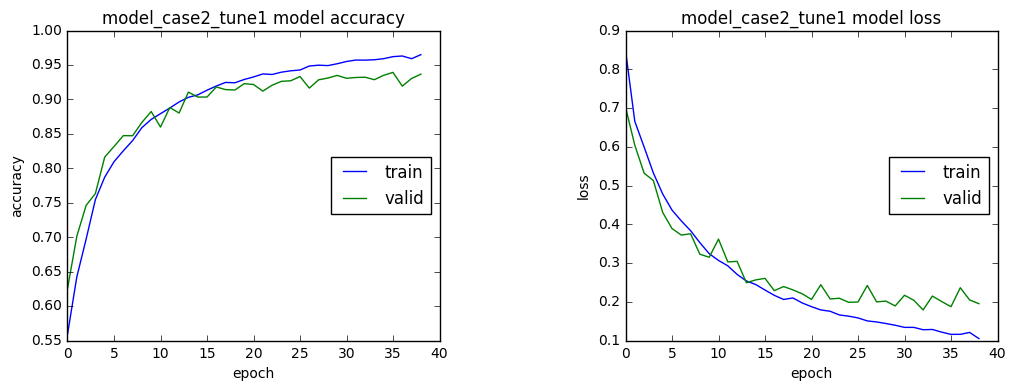

Found 12500 images belonging to 1 classes.


KeyboardInterrupt: 

In [13]:
#model_case2_tune1
import ModelUtil
import importlib
importlib.reload(ModelUtil)
from keras import optimizers

dat_dir = "./trainprocess"
cate_dat_dir = dat_dir + "/categorized"
train_dat_dir = dat_dir + "/train1"
valid_dat_dir = dat_dir + "/valid1"
categories = ["cat", "dog"]
rebuild_dir(train_dat_dir)
rebuild_dir(valid_dat_dir)
dog_train_size, dog_test_size = split_train_valid("dog", 0.2, 1234, False)
cat_train_size, cat_test_size = split_train_valid("cat", 0.2, 1234, False)
total_train_size = 20000 #dog_train_size + cat_train_size
total_valid_size = 5000 #dog_test_size + cat_test_size
'''
dat_dir = "./trainprocess"
cate_dat_dir = dat_dir + "/categorized"
train_dat_dir = dat_dir + "/train"
valid_dat_dir = dat_dir + "/valid"
categories = ["cat", "dog"]

rebuild_dir(train_dat_dir)
rebuild_dir(valid_dat_dir)
dog_train_size, dog_test_size = split_train_valid("dog", 0.3, 1234, False)
cat_train_size, cat_test_size = split_train_valid("cat", 0.3, 1234, False)
total_train_size = 17500 #dog_train_size + cat_train_size
total_valid_size = 7500 #dog_test_size + cat_test_size
'''

image_width = 150
image_height = 150
image_size = (image_width,image_height)
perbatch = 64
poch_num = 150

name_case2_tune1 = "model_case2_tune1"
model_case2_tune1 = ModelUtil.model_mycase2_tune1(image_width, image_height)
adam = optimizers.Adam(lr=0.00001)
#rmsp = optimizers.RMSprop(lr=0.0001)
model_case2_tune1.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
ModelUtil.visualize_model(model_case2_tune1, model_name=name_case2_tune1)
history_case2_tune1 = ModelUtil.train_data_earlystopping(model_case2_tune1, model_name=name_case2_tune1, epoch=poch_num,
                          image_size = (image_width, image_height), num_perbatch=perbatch,
                         train_dir=train_dat_dir, train_size=total_train_size,
                         valid_dir=valid_dat_dir, valid_size=total_valid_size)
ModelUtil.visualize_history(history_case2_tune1, model_name=name_case2_tune1)
ModelUtil.predict_data(model_case2_tune1, model_name=name_case2_tune1, 
                 image_size=(image_width, image_height), 
                 num_perbatch=perbatch)
ModelUtil.save_model(model_case2_tune1, model_name=name_case2_tune1)